# LC-level graph net with PU

In [ ]:
import numpy as np
import torch
import sys
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.nn import DynamicEdgeConv
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

import sklearn.metrics as metrics

from reco.training import train_edge_pred, test_edge_pred, precision_recall_curve, roc_auc
from reco.loss import FocalLoss
from reco.datasetLCPU import LCGraphPU

ds_name = "CloseByGamma200PUFull"

# data_root = "data"
# raw_dir = f"/Users/ecuba/data/{ds_name}"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [13]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
transform = T.Compose([T.NormalizeScale()])

ds = LCGraphPU(
    ds_name + ".2",
    data_root,
    raw_dir,
    # transform=transform,
    N_FILES=464,
    radius=10,
)

ds.processed_file_names

['LCGraphPU_CloseByGamma200PUFull.2_f464_r10_s0.2.pt']

In [15]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}")

# this is very nice - handles the dimensions automatically
train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = DataLoader(test_set, batch_size=32, shuffle=True)

Train graphs: 4724, Test graphs: 524


In [16]:
print("Labels (one per layer-cluster):", len(ds.data.y))

Labels (one per layer-cluster): 3206767


In [17]:
balance = float(sum(ds.data.y > 0.8) / len(ds.data.y))
print(f"dataset balance: {balance * 100:.2f}%") 

dataset balance: 9.22%


In [18]:
class EdgeConvBlock(nn.Module):

    def __init__(self, input_dim, hidden_dim, aggr="add", skip_link=False, k=8):
        super(EdgeConvBlock, self).__init__()

        convnetwork = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        self.dynamicgraphconv = DynamicEdgeConv(nn=convnetwork, aggr=aggr, k=k)
        self.skip_link = skip_link
        
    def forward(self, X, edge_index=None):
        H = self.dynamicgraphconv(X)

        if self.skip_link:
            return torch.hstack((H, X))

        return H    


class LCGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2, skip_link=False):
        super(LCGraphNet, self).__init__()
        # particlenet light
        
        hdim1 = 64
        in_dim2 = hdim1 + input_dim if skip_link else hdim1
        
        hdim2 = 128
        in_dim3 = hdim2 + in_dim2 if skip_link else hdim2

        hdim3 = 256
        # in_dim4 = hdim3 + in_dim3 if skip_link else hdim3

        # EdgeConv
        self.graphconv1 = EdgeConvBlock(input_dim, hdim1, skip_link=skip_link)
        self.graphconv2 = EdgeConvBlock(in_dim2, hdim2, skip_link=skip_link)
        
        # self.graphconv3 = EdgeConvBlock(in_dim3, hdim3, skip_link=skip_link)
        # Edge features from node embeddings for classification
        
        self.edgenetwork = nn.Sequential(
            nn.Linear(in_dim3, hdim3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim3, output_dim),
            nn.Sigmoid()
        )
            
    def forward(self, X, _edge_index=None):   
        
        H = self.graphconv1(X)
        H = self.graphconv2(H)
        # H = self.graphconv3(H)
        
        return self.edgenetwork(H).squeeze(-1)

In [19]:
model = LCGraphNet(input_dim=ds.data.x.shape[1], skip_link=False)
epochs = 201
model_path = f"models/LCGraphNet.64.128.128.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"

In [ ]:
# %%script echo skipping

# alpha - percentage of negative edges
loss_func = FocalLoss(alpha=balance, gamma=2)

model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)

for epoch in range(epochs):

    train_loss, train_true, train_pred = train_edge_pred(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    train_auc = metrics.roc_auc_score((train_true > 0.8).astype(int), train_pred)
    scheduler.step()

    if epoch % 5 == 0:
        test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)
        test_auc = metrics.roc_auc_score((test_true > 0.8).astype(int), test_pred)
        print(
            f"Epoch {epoch}:",
            f"\ttrain loss:{train_loss:.2f}\ttrain auc: {train_auc:.3f}",
            f"\t test loss:{test_loss:.2f} \t test auc: {test_auc:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

In [ ]:
precision_recall_curve(model, device, test_dl, step=2)

In [ ]:
print(roc_auc(model, device, test_dl))

## Results

- (32, 64) + 128, focal loss: balance, no skip: Bacc: 0.75
- (32, 64) + 128, focal loss: 1-balance, no skip: Bacc: 0.56
- (32, 64) + 128, focal loss: 1-balance, skip: Bacc: 0.75
- (64, 64) + 128, focal loss: balance, no skip: Bacc: 0.71

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, fbeta_score, balanced_accuracy_score
import matplotlib.pyplot as plt

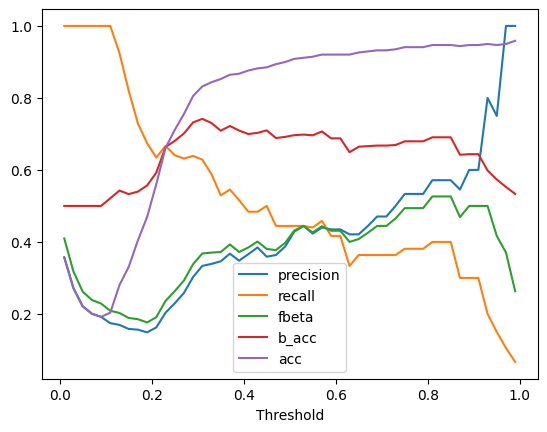

TP: 22, TN: 260, FP: 44, FN: 13
TH: 0.31 precision: 0.333 recall: 0.629 fbeta: 0.368 b_acc: 0.742 acc: 0.832


In [16]:
th_values = [i / 100. for i in range(1, 100, 2)]

focus_metric = "b_acc"

beta = 0.5

result = {
    "precision": [],
    "recall": [],
    "fbeta": [],
    "b_acc": [],
    "acc": [],
}
cm = []

for th in th_values:
    pred = []
    lab = []
    for data in test_dl:

        b = data.x
        l = data.y
        
        tracksters = set(data.trackster_index.tolist())
        
        b = b.to(device)
        l = l.reshape(-1)

        model_pred = model(b).detach().cpu().reshape(-1)
        
        for trackster in tracksters:
            idx = np.where(trackster == data.trackster_index)
            pr = model_pred[idx]
            gt = l[idx]

            pred.append((pr.mean() > th).type(torch.int).item())
            lab.append((gt.mean() > th).type(torch.int).item())

    result["precision"].append(precision_score(lab, pred, zero_division=0))
    result["recall"].append(recall_score(lab, pred))
    result["fbeta"].append(fbeta_score(lab, pred, beta=beta))
    result["b_acc"].append(balanced_accuracy_score(lab, pred))
    result["acc"].append(accuracy_score(lab, pred))
    cm.append(confusion_matrix(lab, pred).ravel())

plt.figure()
for k, v in result.items():
    plt.plot(th_values, v, label=k)

plt.xlabel("Threshold")
plt.legend()
plt.show()

bi = np.argmax(result[focus_metric])
decision_th = th_values[bi]

tn, fp, fn, tp = cm[bi]
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"TH: {decision_th}", " ".join([f"{k}: {v[bi]:.3f}" for k, v in result.items()]))

## Conclusion
- k-nn if very slow, need to introduce a smarter way to deal with the edges